  * https://www.kaggle.com/viridisquotient/arimax
  * Lhttps://www.machinelearningplus.com/time-series/time-series-analysis-python/

In [21]:
import data_prep_helper
import statsmodels.api as sm
import pandas as pd
from math import sqrt
from sklearn.metrics import mean_squared_error
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [22]:
do = data_prep_helper.ChartData()

In [23]:
corr_df = do.chart_df


In [24]:
corr_df = corr_df.resample('D').interpolate()

In [25]:
#creating the train and validation set
train = corr_df[:int(0.8*(len(corr_df)))]
valid = corr_df[int(0.8*(len(corr_df))):]

In [26]:
months = train.index.month
dummy_months = pd.get_dummies(months)
dummy_months.columns = ['month-%s' % m for m in dummy_months.columns]
dummy_months.index = train.index

In [27]:
train['bitcoin_Price_prev_week'] = train['bitcoin_Price'].shift(8)
train['bitcoin_Price_prev_month'] = train['bitcoin_Price'].shift(31)
train['alibaba_Price_prev_month'] = train['alibaba_Price'].shift(31)
train['alibaba_Price_prev_week'] = train['alibaba_Price'].shift(8)
train['amazon_Price_prev_month'] = train['amazon_Price'].shift(31)
train['googl_Price_prev_month'] = train['googl_Price'].shift(31)
train['googl_Price_prev_week'] = train['googl_Price'].shift(8)

train['bitcoin_trends_prev_month'] = train['bitcoin_Google_Trends'].shift(31)
train['bitcoin_trends_prev_week'] = train['bitcoin_Google_Trends'].shift(8)
train['cryptocurrency_trends_prev_month'] = train['cryptocurrency_Google_Trends'].shift(31)
train['cryptocurrency_trends_prev_week'] = train['cryptocurrency_Google_Trends'].shift(8)
train['economy_pos_prev_month'] = train['economy_pos_sents'].shift(31)


#train.fillna(0, inplace=True)
 
train = pd.concat([train, dummy_months.iloc[:,:3]], axis=1)

In [28]:
months = valid.index.month
dummy_months = pd.get_dummies(months)
dummy_months.columns = ['month-%s' % m for m in dummy_months.columns]
dummy_months.index = valid.index



valid['bitcoin_Price_prev_week'] = valid['bitcoin_Price'].shift(8)
valid['bitcoin_Price_prev_month'] = valid['bitcoin_Price'].shift(31)
valid['alibaba_Price_prev_month'] = valid['alibaba_Price'].shift(31)
valid['alibaba_Price_prev_week'] = valid['alibaba_Price'].shift(8)
valid['amazon_Price_prev_month'] = valid['amazon_Price'].shift(31)
valid['googl_Price_prev_month'] = valid['googl_Price'].shift(31)
valid['googl_Price_prev_week'] = valid['googl_Price'].shift(8)

valid['bitcoin_trends_prev_month'] = valid['bitcoin_Google_Trends'].shift(31)
valid['bitcoin_trends_prev_week'] = valid['bitcoin_Google_Trends'].shift(8)
valid['cryptocurrency_trends_prev_month'] = valid['cryptocurrency_Google_Trends'].shift(31)
valid['cryptocurrency_trends_prev_week'] = valid['cryptocurrency_Google_Trends'].shift(8)
valid['economy_pos_prev_month'] = valid['economy_pos_sents'].shift(31)


valid = pd.concat([valid, dummy_months], axis=1)

#train.dropna(inplace=True)
#valid.dropna(inplace=True)

In [29]:
train = train.iloc[31:,:]
#valid = valid.iloc[31:,:]

In [30]:
%%time
s1i1 = train['bitcoin_Price']
exog_s1i1 = train[[
                   'bitcoin_Price_prev_week',
                   'bitcoin_Price_prev_month',
                   'alibaba_Price_prev_week',
                   'googl_Price_prev_month',
                   'bitcoin_trends_prev_week',
                   'bitcoin_trends_prev_month',
                   'cryptocurrency_trends_prev_week',
                   'cryptocurrency_trends_prev_month',
                   'month-1', 'month-2',
                   ]].fillna(0)
    

arimax = sm.tsa.statespace.SARIMAX(s1i1, exog=exog_s1i1,
                                   enforce_invertibility=False, enforce_stationarity=False, freq='D').fit()
print(arimax.summary())

                               SARIMAX Results                                
Dep. Variable:          bitcoin_Price   No. Observations:                 1480
Model:               SARIMAX(1, 0, 0)   Log Likelihood              -10074.021
Date:                Fri, 03 Apr 2020   AIC                          20172.042
Time:                        17:58:54   BIC                          20235.631
Sample:                    02-08-2015   HQIC                         20195.748
                         - 02-26-2019                                         
Covariance Type:                  opg                                         
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
bitcoin_Price_prev_week             -0.0366      0.012     -3.041      0.002      -0.060      -0.013
bitcoin_Price_prev_month            -0.1267      0.019     -6.626

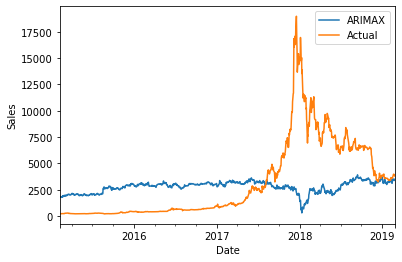

In [31]:


exog = train[[
                   'bitcoin_Price_prev_week',
                   'bitcoin_Price_prev_month',
                   'alibaba_Price_prev_week',
                   #'alibaba_Price_prev_month',
                   #'amazon_Price_prev_month',
                   'googl_Price_prev_month',
                   'bitcoin_trends_prev_week',
                   'bitcoin_trends_prev_month',
                   'cryptocurrency_trends_prev_week',
                   'cryptocurrency_trends_prev_month',
                   'month-1', 'month-2'
                   ]].fillna(0)
forecast =  arimax.predict( dynamic=True, exog=exog)
actual = train["bitcoin_Price"]

forecast.plot()
actual.plot()
plt.legend(['ARIMAX', 'Actual'])
plt.ylabel('Sales');



In [32]:
exog = valid[[
                   'bitcoin_Price_prev_week',
                   'bitcoin_Price_prev_month',
                   'alibaba_Price_prev_week',
                   #'alibaba_Price_prev_month',
                   #'amazon_Price_prev_month',
                   'googl_Price_prev_month',
                   'bitcoin_trends_prev_week',
                   'bitcoin_trends_prev_month',
                   'cryptocurrency_trends_prev_week',
                   'cryptocurrency_trends_prev_month',
                   'month-1', 'month-2'
                   ]].fillna(0)

In [33]:
forecast = arimax.get_forecast(steps=len(valid), exog=exog)

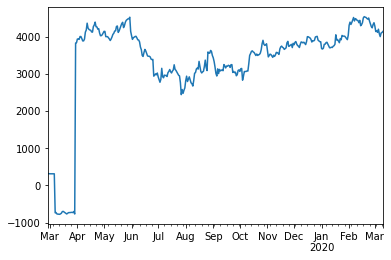

In [34]:
forecast.predicted_mean.plot()
#valid["bitcoin_Price"].plot()

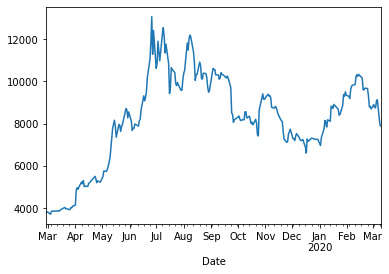

In [35]:
valid["bitcoin_Price"].plot()

In [36]:
sqrt(mean_squared_error(forecast.predicted_mean, valid["bitcoin_Price"]))

5302.804139863473